# Kaggle Titanic Challenge

<b>Problem Statement:</b>
Create a model that predicts who survived Titanic

#### Background: 
- Initially attempted with Logistic Regression, that involved Feature Engineering the ```ticket``` column. It also used ```drop_first=True``` to prevent multicollinearity
- However, that resulted in a score of 77% on Kaggle, even though my test scores locally were 83% accuracy
- I suspected that I might be overfitting the data, hence this 2nd attempt using Random Forest

#### Overview:
- In this notebook, I explored Random Forests instead. 
- For features, I dropped ```Tickets```, and set up categories for age and fare in an attempt to prevent overfitting
- Did not use ```drop_first``` as it is my understanding that it is not necessary for non-regression models
- Also experimented with keeping ```Sex``` and ```Pclass``` as numerical variables, rather than using one-hot encoding
- I also used GridSearch to find the optimal parameters for my model. This also returned better results than my previous attempts
- Alas, this only improved my score by 1% to 78%, even though the test score was 84% :<

#### Next Steps: 
- Try more feature engineering: Derive relations through last name? How do I do that?
- Questions: how do I encode ```Pclass``` and ```Sex```? How do I fix my model if it's overfitting the data?
- How do I know what models to try?
- What is StratifiedKFolds

Credits: I referred extensively to [this tutorial post](https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html) for guidance! 

## Exploratory Data Analysis

### Importing libraries and loading data

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
t = pd.read_csv('train.csv')
t.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Null items for ```Age```, ```Cabin```, and ```Embarked```

In [5]:
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
t.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [38]:
sns.set_style('white')
sns.set_palette('deep')

In [6]:
t.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


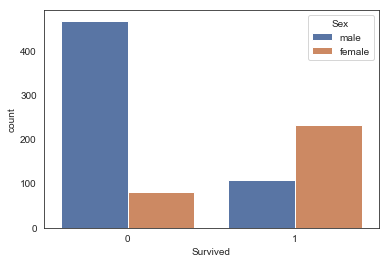

In [45]:
# who is more likely to survive: Males were less likely to survive, compared to females
sns.countplot(x='Survived',data=t, hue='Sex')

In [66]:
#age and class of males who survived
males = t[t['Sex']=='male']

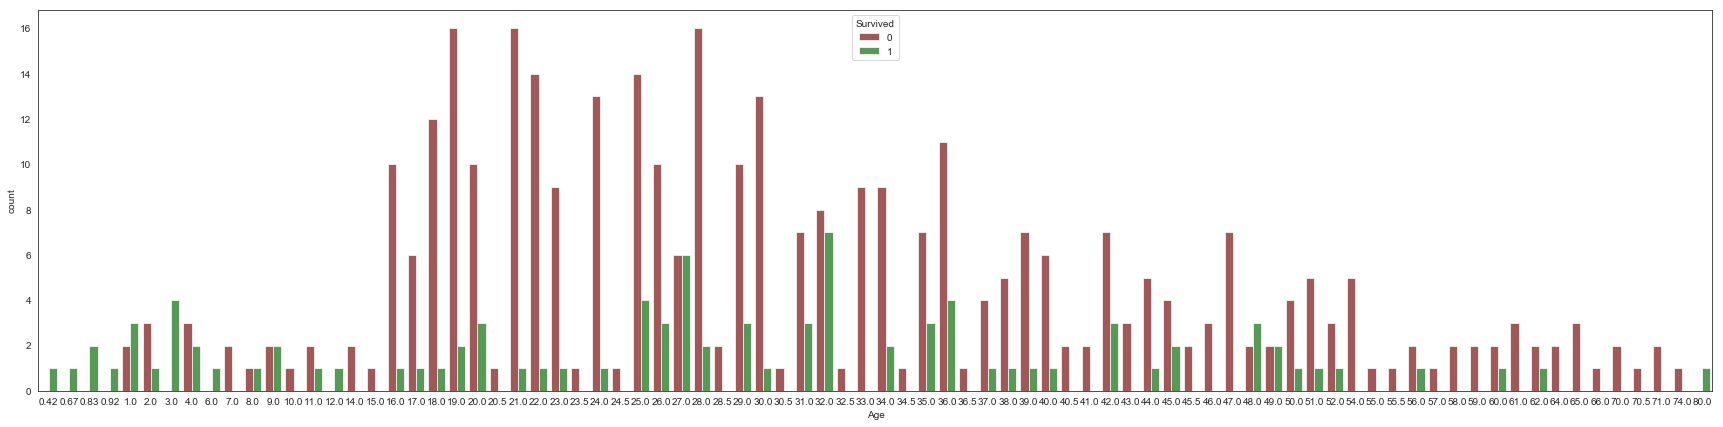

In [59]:
# Infant and children males were more likely to be saved, as well as some men in the 30s and 50s sporadically.
# why are really old men 50+ being saved. Confirm First Class
plt.figure(figsize=(30,7))
sns.countplot(x='Age',data=males, hue='Survived', palette={0:'darkred',1:'green'},alpha=0.7)

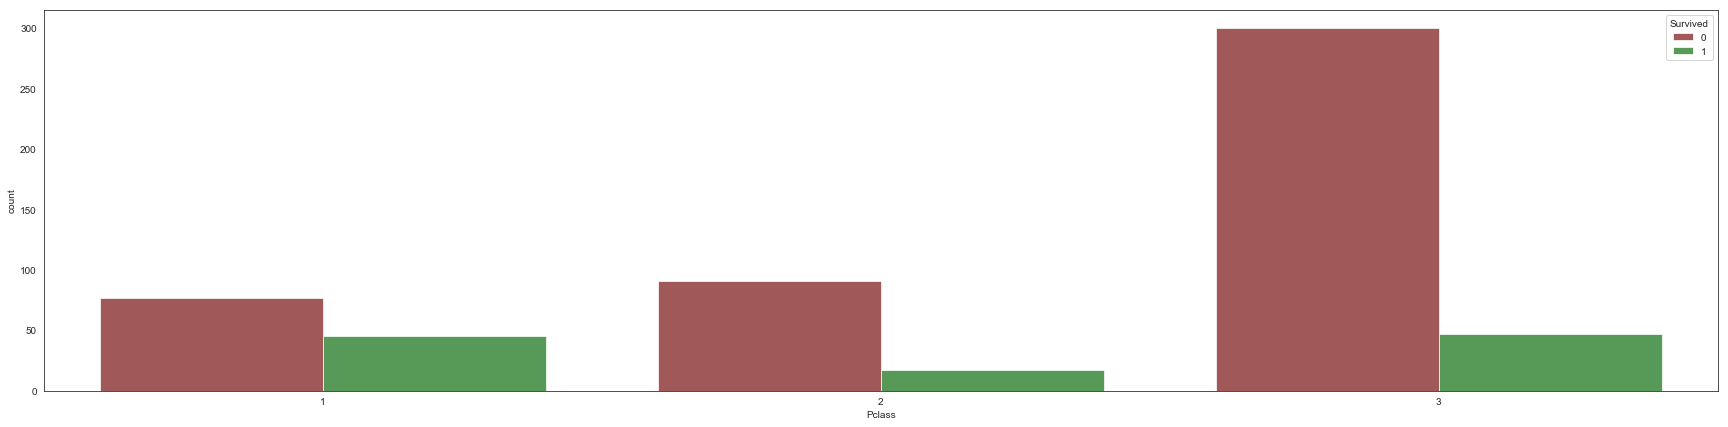

In [64]:
# 1st class men were proportionately more likely to survive
plt.figure(figsize=(30,7))
sns.countplot(x='Pclass',data=males, hue='Survived', palette={0:'darkred',1:'green'},alpha=0.7)

In [67]:
# let's look at it through a stacked bar, but first, getting 'Died' column to compute ratio
t['Died'] = 1 - t['Survived']
t.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


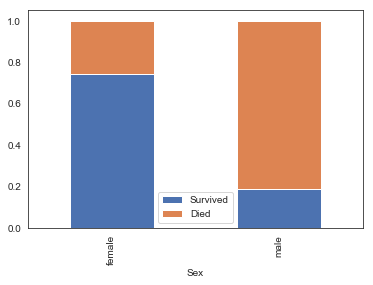

In [70]:
# females are much more likely to survive
t.groupby('Sex').mean()[['Survived','Died']].plot(kind='bar', stacked=True)

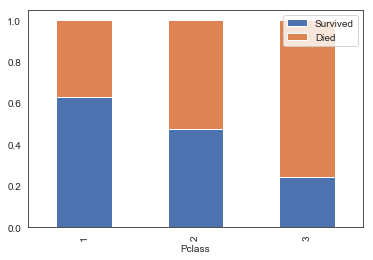

In [73]:
#1st class most likely to survive as well
t.groupby('Pclass').mean()[['Survived','Died']].plot(kind='bar', stacked=True)

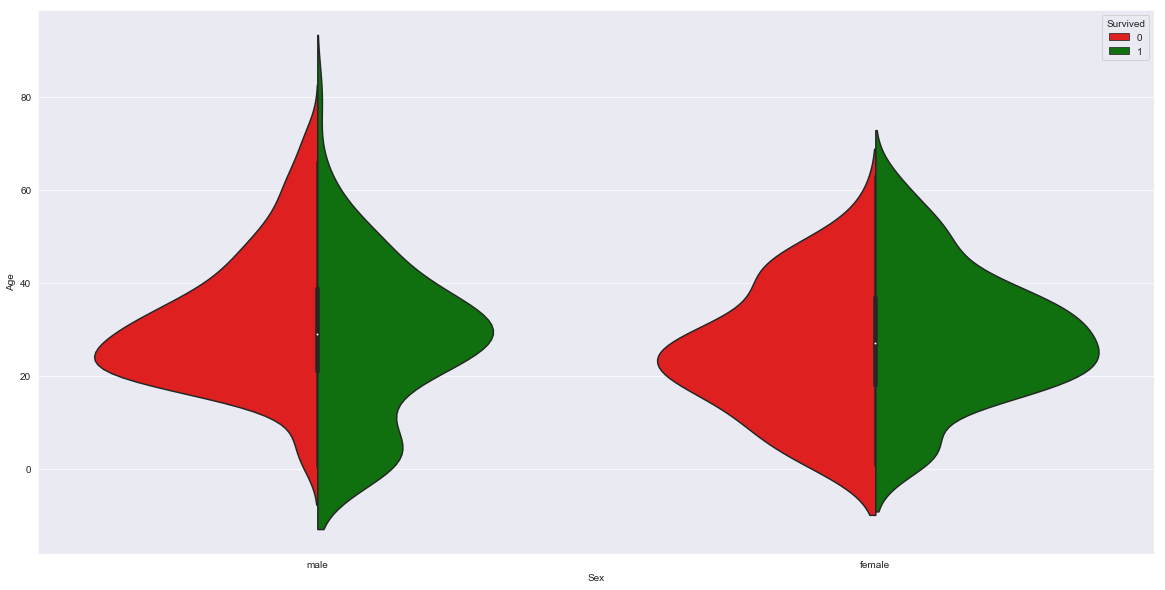

In [90]:
# again, infant males more likely to survive, while age does not really determine whethr or not a woman survives
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
sns.violinplot(x='Sex',y='Age',hue='Survived',data=t,split=True,scale='area',palette={1:'g',0:'r'})

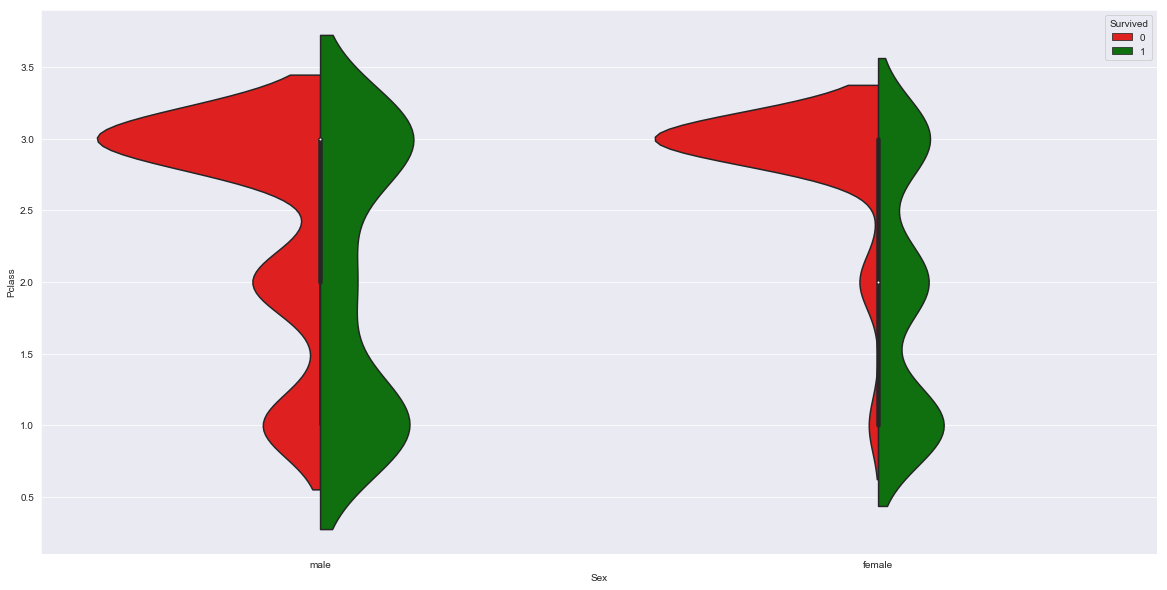

In [94]:
# 3rd class men and women more likely to die, this difference is even more pronounced for females
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
sns.violinplot(x='Sex',y='Pclass',hue='Survived',data=t,split=True,scale='area',palette={1:'g',0:'r'})

In [95]:
t.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


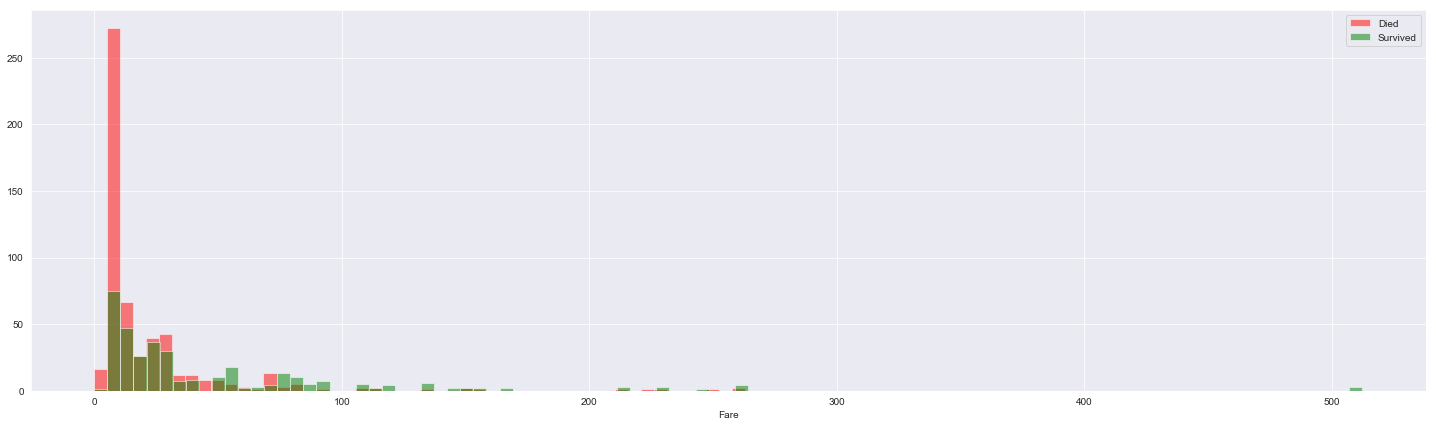

In [119]:
# distribution of ticket fare

plt.figure(figsize=(25,7))
plt.hist(t[t['Survived']==0]['Fare'],bins=50,color='r',alpha=0.5,label='Died')
plt.hist(t[t['Survived']==1]['Fare'],bins=97,color='g',alpha=0.5,label='Survived')
plt.xlabel('Fare')
plt.legend()

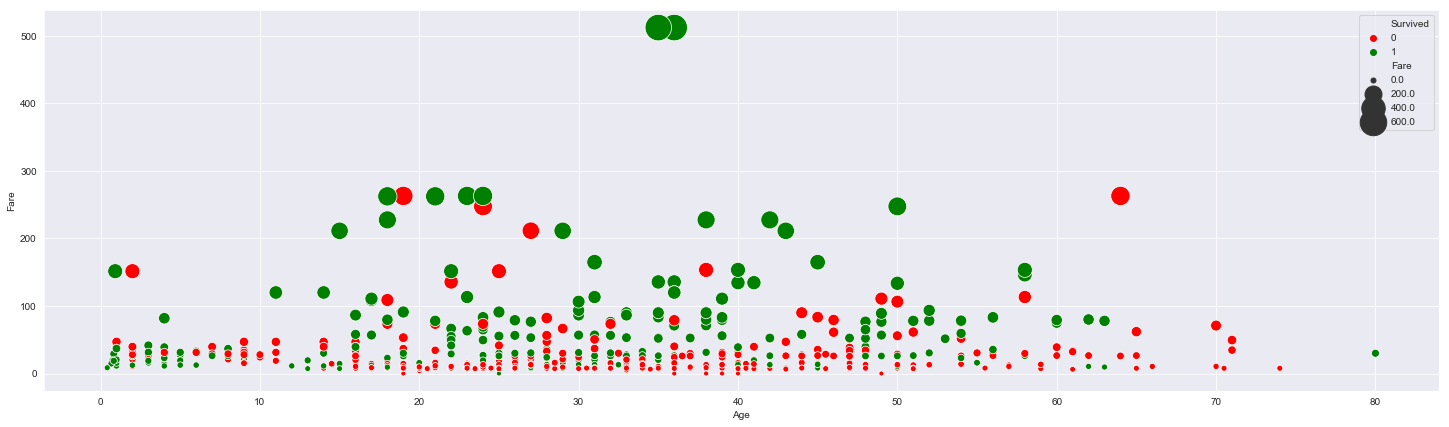

In [185]:
plt.figure(figsize=(25,7))
sns.scatterplot(x='Age',y='Fare',hue='Survived',data=t,
                palette={1:'g',0:'r'},size='Fare',sizes=(25,700))

In [186]:
t[t['Fare']>500]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,0
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,0
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,0


In [190]:
t[t['Fare']>200]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S,1
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S,0
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,1
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,0
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C,0
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,0
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S,0
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C,1
380,381,1,1,"Bidois, Miss. Rosalie",female,42.0,0,0,PC 17757,227.5250,NaN,C,0
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S,1


In [188]:
t[t['Age']>70]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,1
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,1
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C,1
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S,0
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S,1


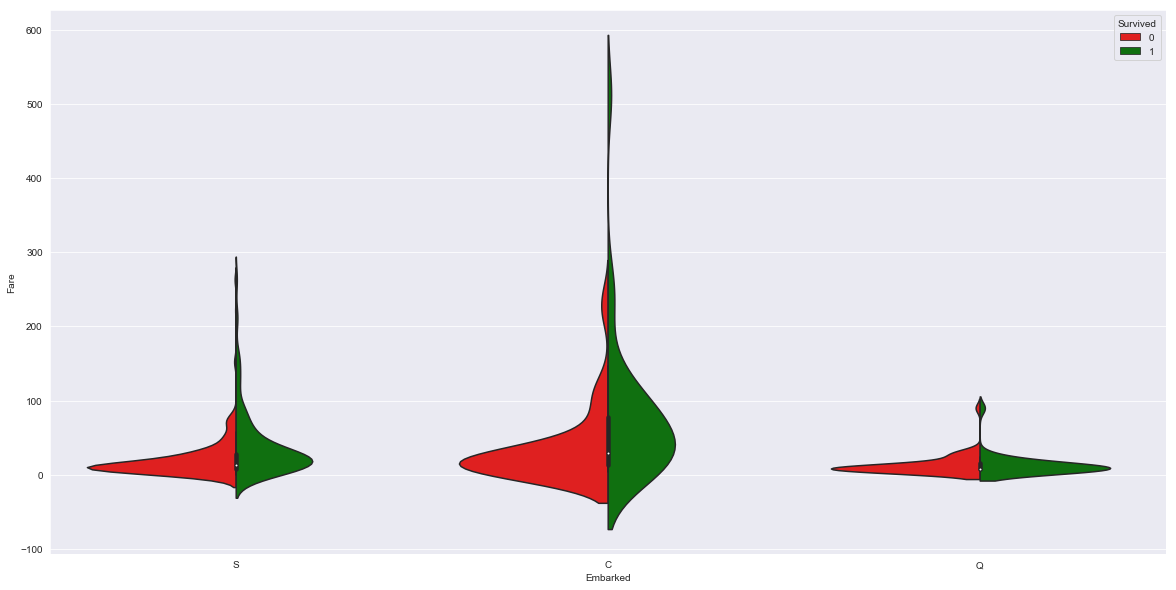

In [197]:
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
sns.violinplot(x='Embarked',y='Fare',hue='Survived',data=t,split=True,scale='area',palette={1:'g',0:'r'})

## Feature Engineering

#### Loading Data

In [5]:
def status(feature):
    print('Processing',feature,': Done')

In [6]:
def combine_data():
    
    # load train data
    train_csv = pd.read_csv('train.csv')
    print('train.csv: {}'.format(train_csv.shape))
    
    # load test data
    test_csv = pd.read_csv('test.csv')
    print('test.csv: {}'.format(test_csv.shape))
    
    # initialise and remove targets from train data
    targets = train_csv['Survived']
    train_csv.drop('Survived',axis=1,inplace=True)
    
    # combining both test and train
    combined = train_csv.append(test_csv,ignore_index=True)
    # removing redundant columns:
    combined.drop('PassengerId',axis=1,inplace=True)
    print('Combined df: {}'.format(combined.shape))
    
    print('Data Combined')
    return combined

In [10]:
combined = combine_data()

train.csv: (891, 12)
test.csv: (418, 11)
Combined df: (1309, 10)
Data Combined


In [11]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 102.3+ KB


In [7]:
combined.head(6)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


#### Splitting out Title

In [12]:
title_dict = (
    {'Mr': 'Mr',
     'Mrs': 'Mrs',
     'Miss': 'Miss',
     'Master': 'Master',
     'Don': 'Nobility',""
     'Rev': 'Religious',
     'Dr': 'Dr',
     'Mme': 'Mrs',
     'Ms': 'Miss',
     'Major': 'Officer',
     'Lady': 'Nobility',
     'Sir': 'Nobility',
     'Mlle': 'Miss',
     'Col': 'Officer',
     'Capt': 'Officer',
     'the Countess': 'Nobility',
     'Jonkheer': 'Nobility',
     'Dona': 'Nobility'
    }
)

def get_title():
    combined['Title'] = combined['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
    combined['Title'] = combined['Title'].map(title_dict)
    return combined

In [13]:
combined = get_title()

In [14]:
combined.head(6)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
5,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr


#### Imputing missing values from ```Embarked```

In [15]:
# 2 missing values from training data, both from 1st class, stayed in the same cabin and paid the same fare.
# likely embarked together
combined.iloc[:891][combined.iloc[:891]['Embarked'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


In [16]:
# no missing data from test data
combined.iloc[891:][combined.iloc[891:]['Embarked'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


In [17]:
# Most of the 1st passengers boarded on S or C
combined.iloc[:891][combined.iloc[:891]['Pclass']==1]['Embarked'].value_counts()

S    127
C     85
Q      2
Name: Embarked, dtype: int64

In [18]:
combined.iloc[:891][combined.iloc[:891]['Pclass']==1]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
6,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr
11,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,Miss
23,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S,Mr
27,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S,Mr
30,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,Nobility
31,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,Mrs
34,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C,Mr
35,1,"Holverson, Mr. Alexander Oskar",male,42.0,1,0,113789,52.0000,NaN,S,Mr


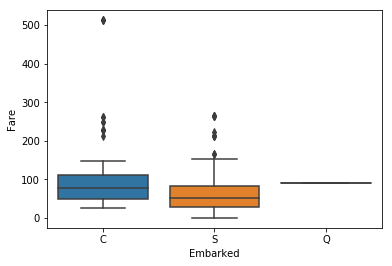

In [19]:
sns.boxplot(x='Embarked',y='Fare',data=combined.iloc[:891][combined.iloc[:891]['Pclass']==1])

In [20]:
combined.iloc[:891][(combined.iloc[:891]['Pclass']==1) & (combined.iloc[:891]['Embarked']=='C')]['Fare'].median()

78.2667

In [21]:
combined.iloc[:891][(combined.iloc[:891]['Pclass']==1) & (combined.iloc[:891]['Embarked']=='S')]['Fare'].median()

52.0

In [22]:
def impute_embarked():
    combined['Embarked'].fillna('C',inplace=True)
    return combined

In [23]:
combined = impute_embarked()

In [24]:
combined.head(6)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
5,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr


In [25]:
find_median_age = combined.iloc[:891].groupby(['Pclass','Sex','Embarked','Title']).median()
find_median_age = find_median_age.reset_index()[['Pclass','Sex','Embarked','Title','Age']]
find_median_age

,Pclass,Sex,Embarked,Title,Age
0,1,female,C,Miss,31.00
1,1,female,C,Mrs,44.00
2,1,female,C,Nobility,48.00
3,1,female,Q,Miss,33.00
4,1,female,S,Dr,49.00
5,1,female,S,Miss,23.00
6,1,female,S,Mrs,39.00
7,1,female,S,Nobility,33.00
8,1,male,C,Dr,32.00
9,1,male,C,Mr,36.00


In [26]:
combined.head(6)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
5,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr


In [27]:
def median_age(row):
    
    stricter_condition = (
        (find_median_age['Pclass'] == row['Pclass']) &
        (find_median_age['Sex'] == row['Sex']) &
        (find_median_age['Embarked'] == row['Embarked']) &
        (find_median_age['Title'] == row['Title'])
    )
    
    condition = (
        (find_median_age['Pclass'] == row['Pclass']) &
        (find_median_age['Sex'] == row['Sex']) &
        (find_median_age['Title'] == row['Title'])
    )
    
# by right, maybe I should create another find_median_age table, cause right now, it's just taking the first
# p-class-sex-title combination
    try:
        return find_median_age[stricter_condition]['Age'].values[0]
    except:
        return find_median_age[condition]['Age'].values[0]


def impute_age():
    combined['Age'] = combined.apply(lambda row: median_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return combined

In [28]:
combined = impute_age()
combined.head(6)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
5,3,"Moran, Mr. James",male,31.5,0,0,330877,8.4583,NaN,Q,Mr


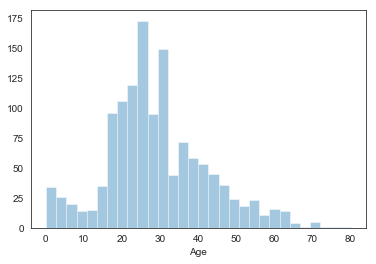

In [31]:
sns.set_style('white')
sns.distplot(combined['Age'],kde=False)

In [76]:
def categorise_age():
    
    def age_category(age):
        if 0 <= age <= 3:
            return '0 - 3 YO'
        elif 4 <= age <= 12:
            return '4 - 12 YO'
        elif 13 <= age <= 17:
            return '13 - 17 YO'
        elif 18 <= age < 35:
            return '18 - 34 YO'
        elif 35 <= age <= 44:
            return '35 - 44 YO'
        elif 45 <= age <= 54:
            return '45 - 54 YO'
        elif 55 <= age <= 69:
            return '55 - 69 YO'
        elif age >= 70:
            return 'above 70 YO'
        
    combined['Age Category'] = combined['Age'].apply(age_category)    
    
    return combined

In [77]:
combined = categorise_age()
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Age Category,Fare Category
0,3,male,22.0,1,0,7.2500,U,S,Mr,18 - 34 YO,6 - 14
1,1,female,38.0,1,0,71.2833,C,C,Mrs,35 - 44 YO,50 - 74
2,3,female,26.0,0,0,7.9250,U,S,Miss,18 - 34 YO,6 - 14
3,1,female,35.0,1,0,53.1000,C,S,Mrs,35 - 44 YO,50 - 74
4,3,male,35.0,0,0,8.0500,U,S,Mr,35 - 44 YO,6 - 14


In [78]:
combined[combined['Age Category'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Age Category,Fare Category


In [37]:
combined[combined['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age Category
1043,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,55 - 69 YO


In [38]:
combined.iloc[:891][combined.iloc[:891]['Pclass']==3].groupby('Title').median()['Fare']

Title
Master    28.51250
Miss       8.75625
Mr         7.89580
Mrs       15.97500
Name: Fare, dtype: float64

In [39]:
combined[combined['Pclass']==3].groupby('Title').median()['Fare']

Title
Master    22.3583
Miss       8.0500
Mr         7.8958
Mrs       15.5000
Name: Fare, dtype: float64

In [40]:
def impute_fare():
    combined['Fare'].fillna(7.8958,inplace=True)
    return combined

In [41]:
combined = impute_fare()

In [42]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Pclass          1309 non-null int64
Name            1309 non-null object
Sex             1309 non-null object
Age             1309 non-null float64
SibSp           1309 non-null int64
Parch           1309 non-null int64
Ticket          1309 non-null object
Fare            1309 non-null float64
Cabin           295 non-null object
Embarked        1309 non-null object
Title           1309 non-null object
Age Category    1303 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 122.8+ KB


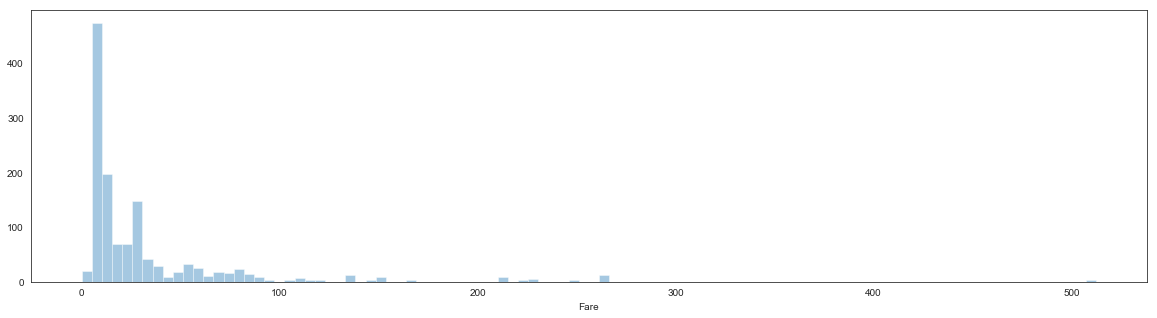

In [49]:
plt.figure(figsize=(20,5))
sns.distplot(combined['Fare'], kde=False, bins=100)

In [53]:
combined['Fare'].sort_values(ascending=True)

466       0.0000
481       0.0000
597       0.0000
413       0.0000
633       0.0000
674       0.0000
1157      0.0000
277       0.0000
271       0.0000
302       0.0000
732       0.0000
822       0.0000
806       0.0000
815       0.0000
1263      0.0000
179       0.0000
263       0.0000
912       3.1708
378       4.0125
872       5.0000
326       6.2375
1007      6.4375
843       6.4375
1024      6.4375
818       6.4500
202       6.4958
1123      6.4958
371       6.4958
654       6.7500
143       6.7500
          ...   
1298    211.5000
1047    221.7792
1005    221.7792
972     221.7792
527     221.7792
557     227.5250
700     227.5250
716     227.5250
1093    227.5250
380     227.5250
1075    247.5208
299     247.5208
118     247.5208
950     262.3750
1266    262.3750
311     262.3750
1033    262.3750
955     262.3750
742     262.3750
915     262.3750
944     263.0000
27      263.0000
341     263.0000
88      263.0000
960     263.0000
438     263.0000
258     512.3292
679     512.32

In [80]:
def categorise_fare():
    def fare_category(fare):
        if fare == 0:
            return '0'
        elif 1 <= fare < 6:
            return '1 - 5'
        elif 6 <= fare < 15:
            return '6 - 14'
        elif 15 <= fare < 30:
            return '15 - 29'
        elif 30 <= fare < 50:
            return '30 - 49'
        elif 50 <= fare < 75:
            return '50 - 74'
        elif 75 <= fare < 100:
            return '75 - 99'
        elif 100 <= fare < 200:
            return '100 - 199'
        elif 200 <= fare < 300:
            return '200 - 299'
        elif fare >= 300:
            return 'above 300'
        
    combined['Fare Category'] = combined['Fare'].apply(fare_category)    
    
    return combined

In [81]:
combined = categorise_fare()

In [82]:
combined[combined['Fare Category'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Age Category,Fare Category


In [60]:
def impute_cabin():
    combined['Cabin'].fillna('U',inplace=True)
    combined['Cabin'] = combined['Cabin'].apply(lambda x: x.split(' ')[0][0])
    return combined

In [62]:
combined = impute_cabin()

In [63]:
def process_ticket():    
    combined['Ticket'] = combined['Ticket'].apply(lambda x: 
                                                  'no_cat' if x.split(' ')[0].isdigit() else x.split(' ')[0])
    return combined

In [64]:
combined = process_ticket()

In [67]:
combined.drop('Ticket',axis=1,inplace=True)

In [69]:
combined_with_name = combined.copy()

In [70]:
combined.drop('Name',axis=1,inplace=True)
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Age Category,Fare Category
0,3,male,22.0,1,0,7.2500,U,S,Mr,18 - 34 YO,6 - 14
1,1,female,38.0,1,0,71.2833,C,C,Mrs,35 - 44 YO,50 - 74
2,3,female,26.0,0,0,7.9250,U,S,Miss,18 - 34 YO,6 - 14
3,1,female,35.0,1,0,53.1000,C,S,Mrs,35 - 44 YO,50 - 74
4,3,male,35.0,0,0,8.0500,U,S,Mr,35 - 44 YO,6 - 14


In [83]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
Pclass           1309 non-null int64
Sex              1309 non-null object
Age              1309 non-null float64
SibSp            1309 non-null int64
Parch            1309 non-null int64
Fare             1309 non-null float64
Cabin            1309 non-null object
Embarked         1309 non-null object
Title            1309 non-null object
Age Category     1309 non-null object
Fare Category    1309 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 112.6+ KB


#### Getting dem Dummies~ 

In [51]:
combined = combine_data()
combined = get_title()
combined = impute_embarked()
combined = impute_age()
combined = impute_cabin()
combined = impute_fare()
combined = process_ticket()

train.csv: (891, 12)
test.csv: (418, 11)
Combined df: (1309, 10)
Data Combined


In [84]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Age Category,Fare Category
0,3,male,22.0,1,0,7.2500,U,S,Mr,18 - 34 YO,6 - 14
1,1,female,38.0,1,0,71.2833,C,C,Mrs,35 - 44 YO,50 - 74
2,3,female,26.0,0,0,7.9250,U,S,Miss,18 - 34 YO,6 - 14
3,1,female,35.0,1,0,53.1000,C,S,Mrs,35 - 44 YO,50 - 74
4,3,male,35.0,0,0,8.0500,U,S,Mr,35 - 44 YO,6 - 14


In [85]:
def process_title():
    global combined
    title_dummies = pd.get_dummies(combined['Title'], prefix='Title')
    combined = pd.concat([combined,title_dummies],axis=1)
    combined.drop('Title',inplace=True, axis=1)
    return combined

In [86]:
combined = process_title()

In [87]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age Category,Fare Category,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Nobility,Title_Officer,Title_Religious
0,3,male,22.0,1,0,7.2500,U,S,18 - 34 YO,6 - 14,0,0,0,1,0,0,0,0
1,1,female,38.0,1,0,71.2833,C,C,35 - 44 YO,50 - 74,0,0,0,0,1,0,0,0
2,3,female,26.0,0,0,7.9250,U,S,18 - 34 YO,6 - 14,0,0,1,0,0,0,0,0
3,1,female,35.0,1,0,53.1000,C,S,35 - 44 YO,50 - 74,0,0,0,0,1,0,0,0
4,3,male,35.0,0,0,8.0500,U,S,35 - 44 YO,6 - 14,0,0,0,1,0,0,0,0


In [92]:
def process_sex():
    global combined
    
    combined['Sex'] = combined['Sex'].apply(lambda x: 0 if x=='male' else 1)

    return combined

In [93]:
combined = process_sex()
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age Category,Fare Category,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Nobility,Title_Officer,Title_Religious
0,3,0,22.0,1,0,7.2500,U,S,18 - 34 YO,6 - 14,0,0,0,1,0,0,0,0
1,1,1,38.0,1,0,71.2833,C,C,35 - 44 YO,50 - 74,0,0,0,0,1,0,0,0
2,3,1,26.0,0,0,7.9250,U,S,18 - 34 YO,6 - 14,0,0,1,0,0,0,0,0
3,1,1,35.0,1,0,53.1000,C,S,35 - 44 YO,50 - 74,0,0,0,0,1,0,0,0
4,3,0,35.0,0,0,8.0500,U,S,35 - 44 YO,6 - 14,0,0,0,1,0,0,0,0


In [94]:
def process_cabin():
    global combined
    cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')
    combined = pd.concat([combined,cabin_dummies],axis=1)
    combined.drop('Cabin',inplace=True, axis=1)
    return combined

In [95]:
combined = process_cabin()
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age Category,Fare Category,Title_Dr,...,Title_Religious,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,0,22.0,1,0,7.2500,S,18 - 34 YO,6 - 14,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,C,35 - 44 YO,50 - 74,0,...,0,0,0,1,0,0,0,0,0,0
2,3,1,26.0,0,0,7.9250,S,18 - 34 YO,6 - 14,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,35.0,1,0,53.1000,S,35 - 44 YO,50 - 74,0,...,0,0,0,1,0,0,0,0,0,0
4,3,0,35.0,0,0,8.0500,S,35 - 44 YO,6 - 14,0,...,0,0,0,0,0,0,0,0,0,1


In [96]:
def process_embarked():
    global combined
    embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
    combined = pd.concat([combined,embarked_dummies],axis=1)
    combined.drop('Embarked',inplace=True, axis=1)
    return combined

In [97]:
combined = process_embarked()
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Age Category,Fare Category,Title_Dr,Title_Master,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,18 - 34 YO,6 - 14,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,35 - 44 YO,50 - 74,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1,26.0,0,0,7.9250,18 - 34 YO,6 - 14,0,0,...,0,0,0,0,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,35 - 44 YO,50 - 74,0,0,...,1,0,0,0,0,0,0,0,0,1
4,3,0,35.0,0,0,8.0500,35 - 44 YO,6 - 14,0,0,...,0,0,0,0,0,0,1,0,0,1


In [98]:
def process_agecat():
    global combined
    agecat_dummies = pd.get_dummies(combined['Age Category'], prefix='AgeCat')
    combined = pd.concat([combined, agecat_dummies],axis=1)
    combined.drop('Age Category',axis=1, inplace=True)
    return combined

In [99]:
combined = process_agecat()
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Fare Category,Title_Dr,Title_Master,Title_Miss,...,Embarked_Q,Embarked_S,AgeCat_0 - 3 YO,AgeCat_13 - 17 YO,AgeCat_18 - 34 YO,AgeCat_35 - 44 YO,AgeCat_4 - 12 YO,AgeCat_45 - 54 YO,AgeCat_55 - 69 YO,AgeCat_above 70 YO
0,3,0,22.0,1,0,7.2500,6 - 14,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,1,1,38.0,1,0,71.2833,50 - 74,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,1,26.0,0,0,7.9250,6 - 14,0,0,1,...,0,1,0,0,1,0,0,0,0,0
3,1,1,35.0,1,0,53.1000,50 - 74,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,3,0,35.0,0,0,8.0500,6 - 14,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [100]:
def process_farecat():
    global combined
    farecat_dummies = pd.get_dummies(combined['Fare Category'], prefix='FareCat')
    combined = pd.concat([combined, farecat_dummies],axis=1)
    combined.drop('Fare Category',axis=1, inplace=True)
    return combined

In [101]:
combined = process_farecat()
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Dr,Title_Master,Title_Miss,Title_Mr,...,FareCat_0,FareCat_1 - 5,FareCat_100 - 199,FareCat_15 - 29,FareCat_200 - 299,FareCat_30 - 49,FareCat_50 - 74,FareCat_6 - 14,FareCat_75 - 99,FareCat_above 300
0,3,0,22.0,1,0,7.2500,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,1,38.0,1,0,71.2833,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,1,26.0,0,0,7.9250,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1,35.0,1,0,53.1000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3,0,35.0,0,0,8.0500,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [103]:
combined.drop(['Age','Fare'],axis=1,inplace=True)

In [65]:
#def process_class():
    global combined
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix='Pclass',drop_first=True)
    combined = pd.concat([combined,pclass_dummies],axis=1)
    combined.drop('Pclass',inplace=True, axis=1)
    return combined

In [66]:
#combined = process_class()
combined.head()

,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Nobility,Title_Officer,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,22.0,1,0,7.2500,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1
1,38.0,1,0,71.2833,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26.0,0,0,7.9250,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,35.0,1,0,53.1000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,35.0,0,0,8.0500,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1


In [104]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 42 columns):
Pclass                1309 non-null int64
Sex                   1309 non-null int64
SibSp                 1309 non-null int64
Parch                 1309 non-null int64
Title_Dr              1309 non-null uint8
Title_Master          1309 non-null uint8
Title_Miss            1309 non-null uint8
Title_Mr              1309 non-null uint8
Title_Mrs             1309 non-null uint8
Title_Nobility        1309 non-null uint8
Title_Officer         1309 non-null uint8
Title_Religious       1309 non-null uint8
Cabin_A               1309 non-null uint8
Cabin_B               1309 non-null uint8
Cabin_C               1309 non-null uint8
Cabin_D               1309 non-null uint8
Cabin_E               1309 non-null uint8
Cabin_F               1309 non-null uint8
Cabin_G               1309 non-null uint8
Cabin_T               1309 non-null uint8
Cabin_U               1309 non-null uint8
Embarked_C 

## Modelling

In [105]:
def rec_train_test():
    
    targets = pd.read_csv('train.csv',usecols=['Survived'])['Survived'].values
    train = combined[:891]
    test = combined[891:]
    
    return targets, train, test

In [106]:
targets, train, test = rec_train_test()

In [107]:
from sklearn.model_selection import train_test_split

In [108]:
X_train, X_test, y_train, y_test = train_test_split(train, targets, test_size=0.3)

In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
rfc = RandomForestClassifier()

In [111]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [112]:
rfc_pred = rfc.predict(X_test)

In [113]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import cross_val_score

In [115]:
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))
print(accuracy_score(y_test,rfc_pred))
print(cross_val_score(rfc, X_train, y_train, cv=10,scoring='accuracy').mean())
print(cross_val_score(rfc, X_train, y_train, cv=10,scoring='accuracy').std())

[[154  20]
 [ 29  65]]
             precision    recall  f1-score   support

          0       0.84      0.89      0.86       174
          1       0.76      0.69      0.73        94

avg / total       0.81      0.82      0.81       268

0.8171641791044776
0.7900233352639487
0.052790809690900234


So far, tweaking the features and categorizing the features have increased the score by 3%

Next, use gridsearch to tune parameters. Aim is to increase scores for Survival.

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [117]:
parameter_grid = {'n_estimators': [10, 30, 50, 75, 100],
                  'max_depth': [None, 2, 4, 6, 10],
                  'min_samples_split': [2, 4, 6, 8],
                  'min_samples_leaf': [1, 2, 5, 10],
                  'max_features': ['auto','sqrt','log2'],
                  'bootstrap': [True, False]
                 }

grid_search = GridSearchCV(RandomForestClassifier(), parameter_grid, scoring='accuracy', 
                           cv = StratifiedKFold(n_splits=5), verbose=1)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=1)]: Done 12000 out of 12000 | elapsed: 12.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 30, 50, 75, 100], 'max_depth': [None, 2, 4, 6, 10], 'min_samples_split': [2, 4, 6, 8], 'min_samples_leaf': [1, 2, 5, 10], 'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [118]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [119]:
gs_pred = grid_search.predict(X_test)

In [120]:
print(confusion_matrix(y_test,gs_pred))
print(classification_report(y_test,gs_pred))
print(accuracy_score(y_test,gs_pred))

[[157  17]
 [ 24  70]]
             precision    recall  f1-score   support

          0       0.87      0.90      0.88       174
          1       0.80      0.74      0.77        94

avg / total       0.85      0.85      0.85       268

0.8470149253731343


### 4% increase in overall accuracy score. and more importantly, precision score for Survival went up to 80%

Running the model on final test data and exporting submission file:

In [121]:
final_output = grid_search.predict(test)

In [122]:
output = pd.DataFrame()

In [126]:
output['PassengerId'] = pd.read_csv('test.csv')['PassengerId']

In [128]:
output['Survived'] = final_output

In [130]:
output.to_csv('kaggle-titanic-submission-2.csv', index=False)

## Appendix

#### Score from 1st Random Forest that used 73 features, because of Ticket breakdown

In [717]:
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[141  26]
 [ 32  69]]
             precision    recall  f1-score   support

          0       0.82      0.84      0.83       167
          1       0.73      0.68      0.70       101

avg / total       0.78      0.78      0.78       268



In [710]:
from sklearn.metrics import accuracy_score

In [724]:
print(accuracy_score(y_test,pred))

0.7835820895522388


In [712]:
from sklearn.model_selection import cross_val_score

In [721]:
cross_val_score(rfc, X_train, y_train, cv=10,scoring='accuracy').mean()

0.815402585765489

In [723]:
cross_val_score(rfc, X_train, y_train, cv=10, scoring = 'accuracy').std()

0.04044264167027802

#### Trying Besbes's implementation

In [745]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [747]:
parameter_grid = {'n_estimators': [5, 10, 30, 50],
                  'max_depth': [None, 2, 4, 6],
                  'min_samples_split': [2, 4, 6],
                  'min_samples_leaf': [1, 2, 5, 10],
                  'max_features': ['auto','sqrt','log2'],
                  'bootstrap': [True, False]
                 }


grid_search = GridSearchCV(RandomForestClassifier(), parameter_grid, scoring='accuracy', 
                           cv = StratifiedKFold(n_splits=5), verbose=1)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=1)]: Done 5760 out of 5760 | elapsed:  2.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 30, 50], 'max_depth': [None, 2, 4, 6], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2, 5, 10], 'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [748]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 50}

In [749]:
pred_gs = grid_search.predict(X_test)

In [751]:
print(confusion_matrix(y_test,pred_gs))
print(classification_report(y_test,pred_gs))
print(accuracy_score(y_test,pred_gs))

[[151  16]
 [ 34  67]]
             precision    recall  f1-score   support

          0       0.82      0.90      0.86       167
          1       0.81      0.66      0.73       101

avg / total       0.81      0.81      0.81       268

0.8134328358208955


In [752]:
combined.head()

,Pclass,Age,SibSp,Parch,Ticket,Fare,Title_Dr,Title_Master,Title_Miss,Title_Mr,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,A/5,7.2500,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,1,38.0,1,0,PC,71.2833,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,26.0,0,0,STON/O2.,7.9250,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,1,35.0,1,0,no_cat,53.1000,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,3,35.0,0,0,no_cat,8.0500,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


In [758]:
combined.head()

,Pclass,Age,SibSp,Parch,Fare,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,3,26.0,0,0,7.9250,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,3,35.0,0,0,8.0500,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [759]:
train2 = combined[:891]
test2 = combined[891:]

In [760]:
X_train, X_test, y_train, y_test = train_test_split(train2, targets, test_size=0.3)

In [765]:
rfc2 = RandomForestClassifier()

In [766]:
rfc2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [767]:
pred_rfc2 = rfc2.predict(X_test)

In [768]:
print(confusion_matrix(y_test,pred_rfc2))
print(classification_report(y_test,pred_rfc2))
print(accuracy_score(y_test,pred_rfc2))
print(cross_val_score(rfc2, X_train, y_train, cv=10,scoring='accuracy').mean())
print(cross_val_score(rfc2, X_train, y_train, cv=10,scoring='accuracy').std())

[[148  25]
 [ 19  76]]
             precision    recall  f1-score   support

          0       0.89      0.86      0.87       173
          1       0.75      0.80      0.78        95

avg / total       0.84      0.84      0.84       268

0.835820895522388
0.7899347787766613
0.056541293054578216
